<a href="https://colab.research.google.com/github/jdmelendez/CSRNet-pytorch/blob/master/CNN/Object-Detection/DETECCION_Entrenamiento_Validacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title ######ACCESO A GOOGLE DRIVE
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wH8KVGEeR0WOvoB2iilNbahInMprBsFsMMswkUonXT4Y6ee9StiBMs
Mounted at /content/gdrive


In [ ]:
#@title ######CARGA LIBRERIAS 

import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import ConnectionPatch
 
import torch
import torchvision.transforms as T
import torchvision
from torchsummary import summary
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import datasets, transforms, models, utils
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
torch.backends.cudnn.benchmarck = True
 
import numpy as np
import math 
import cv2
import time
import os,sys
from PIL import Image
import glob
import xml.etree.cElementTree as ET
import os
import csv
import pandas as pd
import io
from os.path import basename
from pathlib import Path
from random import randint, uniform,random
from IPython.display import display
 
from sklearn import metrics
from sklearn import preprocessing
 
np.random.seed(0)
id = randint(0,1000)

# **MENÚ DE SELECCIÓN**
 
---

In [ ]:
#@title **ANÁLISIS - PATÓGENO:**
# Parametros de carga de datos segun estructura de carpetas en Google Drive y expotacion a PDF:
#tipo_analisis = "Aguas - Deteccion"
#tipo_patogeno = "Aerobios Mesofilos"
tipo_analisis = 'Aguas - Deteccion' #@param ["Aguas - Deteccion", "Challenge - Deteccion"]{allow-input: false}
tipo_patogeno = 'Aerobios Mesofilos' #@param ["Aspergillus Brasiliensis","Burkholderia Cepacia", "Candida Albicans","Escherichia Coli","Pseudomonas Aeruginosa","Staphylococcus Aureus","Aerobios Mesofilos","Mohos y levaduras"]{allow-input: false}

Entrenar_modelo = False #@param {type:"boolean"}
#Validar_modelo = True #@param {type:"boolean"}
path_modelos_entrenados = f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/Modelos entrenados/"
path_modelos_entrenados = os.listdir(path_modelos_entrenados)
print(path_modelos_entrenados)
# tipo analisis:
#   1. Aguas - Deteccion
#   2. Challenge - Deteccion
 
# tipo patogeno:
#   1. Candida Albicans
#   2. Aerobios Mesofilos
#   3. Burkholderia Cepacia
#   4. Mohos y levaduras
#   5. Aspergillus Brasiliensis
#   6. Staphylococcus Aureus
#   7. Escherichia Coli
#   8. Staphylococcus Aureus
#   9. Pseudomonas Aeruginosa

[]


In [ ]:
if Entrenar_modelo == False:
  Nombre_Fichero_modelo_a_validar =  "230-AG-AM.pt" #@param {type:"string"}

In [ ]:
#@title **HIPERPARÁMETROS:** { output-height: 100 }
batch_size = 4 #@param {type:"slider", min:0, max:100, step:1}
batch_size_test = 1 #@param {type:"slider", min:0, max:100, step:1}
n_epochs = 17 #@param {type:"slider", min:0, max:40, step:1}

In [ ]:
#@title **PARÁMETROS - OPTIMIZADOR:**
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.25, step:0.01}
momentum = 0.9 #@param {type:"slider", min:0.5, max:1, step:0.05}
weight_decay = 0.0005 #@param {type:"number"}

In [ ]:
#@title **PARÁMETROS - FILTRO:**
tipo_filtro = 'Rudimentario' #@param ["Rudimentario", "NMS","Soft-NMS"]{allow-input: false}
score_threshold = 0.3 #@param {type:"slider", min:0, max:1, step:0.05}
iou_threshold = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
dist_eucl_threshold = 85 #@param {type:"slider", min:0, max:100, step:5}

In [ ]:
#@title ##### IDENTIFICADOR SELECCIÓN
if tipo_analisis == "Challenge - Deteccion":
  id_analisis = "CH"

elif tipo_analisis == "Aguas - Deteccion":
  id_analisis = "AG"

if tipo_patogeno == "Candida Albicans":
  id_patogeno = "CA"
elif tipo_patogeno == "Burkholderia Cepacia":
  id_patogeno ="BC"
elif tipo_patogeno == "Aspergillus Brasiliensis":
  id_patogeno ="AB"
elif tipo_patogeno == "Escherichia Coli":
  id_patogeno ="EC"
elif tipo_patogeno == "Pseudomonas Aeruginosa":
  id_patogeno = "PA"
elif tipo_patogeno == "Staphylococcus Aureus":
  id_patogeno ="SA"
elif tipo_patogeno == "Aerobios Mesofilos":
  id_patogeno ="AM"

print(f'{tipo_analisis} - {tipo_patogeno}')
print(id,id_analisis, id_patogeno)

Aguas - Deteccion - Aerobios Mesofilos
726 AG AM


#**LIBRERIAS**

---



In [ ]:
#@title GITHUB
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
pip install -U 'git+https://github.com/jdmelendez/PyCocoTools.git#subdirectory=PythonAPI'

  Cloning https://github.com/jdmelendez/PyCocoTools.git to /tmp/pip-req-build-ogdb1t3_
  Running command git clone -q https://github.com/jdmelendez/PyCocoTools.git /tmp/pip-req-build-ogdb1t3_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266586 sha256=4b9ba53b60fc15ff30209b8adc33cdcf689b445d5b3f6c36d7ac15e3d5f7de5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1bn6fsw9/wheels/79/68/07/613749114c98c026c7d617726f564664c577eaf1db4aa4d60e
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


#**PREPARACIÓN DATASETS**

---




#### CREACION DATALOADER

In [ ]:
class MyDataLoader(torch.utils.data.Dataset):
      def __init__(self, path_to_imgs, path_to_anns,transforms):
        self.path_to_imags = path_to_imgs
        self.path_to_anns = path_to_anns
        self.imgs = list(sorted(os.listdir(path_to_imgs)))
        self.anns = list(sorted(os.listdir(path_to_anns)))
        self.transforms = transforms

      def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.path_to_imags, self.imgs[idx])
        ann_path = os.path.join(self.path_to_anns, self.anns[idx])

        path_filename= Path(img_path)
        filename=path_filename.stem

        # Images 
        img = Image.open(img_path).convert("RGB")               

        # Annotations
        annotation_xml = ET.parse(ann_path)
        root = annotation_xml.getroot()
        header = ["xmin","ymin","width","heigth"]
        boxes = []

        for i in root:
            data_string =i.text 

        if data_string == "- ":
          No_labels = True
          size_img = img.size[1]
          xmin = int((size_img/4))
          ymin = int((size_img/4))
          xmax = int((3*size_img/4))
          ymax = int((3*size_img/4))
          boxes.append([xmin, ymin, xmax, ymax])  
        
        else:
          No_labels = False
          data = io.StringIO(data_string.strip())
          df = pd.read_csv(data, sep=",", header=None,names=header,lineterminator=";")        

          # Obtenemos boxes          
          for index, row in df.iterrows():
              xmax =int((row['width']))+int((row['xmin']))
              ymax =int((row['heigth']))+int((row['ymin']))
              xmin =int((row['xmin']))
              ymin =int((row['ymin']))
              boxes.append([xmin, ymin, xmax, ymax])

          # Labels
          n_objs = len(df.index)

        # Convertimos todo en tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if No_labels == True:
          labels = torch.zeros((1,), dtype=torch.int64)
          iscrowd = torch.zeros((1,), dtype=torch.int64)
        else:
          labels = torch.ones((n_objs,), dtype=torch.int64)
          iscrowd = torch.zeros((n_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        

        # Creamos Diccionario
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        #target["filename"] = filename

        # Transformamos en tensor imagen y diccionario
        if self.transforms is not None:
          img, target = self.transforms(img, target)

        return img, target #filename

      def __len__(self):
        return len(self.imgs)

      

**PATHS TRAINING Y TEST**

In [ ]:
path_dir = f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/dataset_entrenamiento/"  # Ruta de carpeta que contiene las clases TODO

In [ ]:
path_img = os.path.join(path_dir, "Images")
path_ann = os.path.join(path_dir, "Annotations")

imgs_names = list(sorted(os.listdir(path_img)))


FileNotFoundError: ignored

**TRANSFORMACIONES**

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.
# git clone https://github.com/Melendez95/vision.git
# cd vision


git clone https://github.com/jdmelendez/Detection-Coco.git
cd Detection-Coco

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'Detection-Coco'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 530 (delta 47), reused 0 (delta 0), pack-reused 456
Receiving objects: 100% (530/530), 5.75 MiB | 4.49 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

**APLICACION DE DATALOADER**

In [ ]:
# Carga de dataset y aplicacion de transformaciones
dataset = MyDataLoader(path_img,path_ann,get_transform(train=False))
dataset_test = MyDataLoader(path_img,path_ann,get_transform(train=False))

# Division en conjunto de training y validation
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_size = 0.1  # Porcentaje del set de entrenamiento usado para validación TODO
split = int(np.floor(valid_size * num_train))
dataset_train = torch.utils.data.Subset(dataset, indices[split:])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:split])



train_loader = torch.utils.data.DataLoader(dataset_train, 
                                           batch_size=batch_size, 
                                           collate_fn=utils.collate_fn, pin_memory = True, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size_test,
                                          collate_fn=utils.collate_fn,pin_memory = True, num_workers=2)

print("Cantidad de imagenes de entrenamiento:",len(dataset_train))
print("Cantidad de imagenes de test:",len(dataset_test))


**PLOT DE IMAGENES + ETIQUETAS**

In [ ]:
# fig = plt.figure(figsize=(30, 30))

# for i in range(4):
#   j=randint(1,len(dataset_train))
#   img, ann= dataset_train[j]
  
#   ax = fig.add_subplot(1,4, i + 1, xticks=[], yticks=[])  
#   ax.spines['left'].set_linewidth(0)
#   ax.spines['right'].set_linewidth(0)
#   ax.spines['bottom'].set_linewidth(0)
#   ax.spines['top'].set_linewidth(0) 


#   npimg=img.numpy()  
#   plt.imshow(np.transpose(npimg,(1,2,0)))
#   plt.show

#   boxes = ann['boxes']
#   boxes=boxes.numpy()
#   colonias = len(boxes)
#   ax.set_title(f"Nº Colonias: {colonias}",color="black",fontsize=15,fontweight='bold')

#   for i in boxes:
#     xmax =int(i[2])
#     ymax =int(i[3])
#     xmin =int(i[0])
#     ymin =int(i[1])
#     width = xmax-xmin
#     heigth = ymax-ymin
#     rect = patches.Rectangle((xmin,ymin), width, heigth, edgecolor ='r', facecolor = 'none',linewidth=1.5)
#     ax.add_patch(rect)



#**ARQUITECURA DE MODELO**

---



#### MODELO PRE-ENTRENADO




In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Cantidad de clases que tenemos (backgound + colonia)
num_classes = 2

# Obtenemos el numero de caracteristicas de entrada al clasificador
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Reemplazamos la cabecera de la red pre-trained por la nueva
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Cantidad maxima de objetos a detectar
model.roi_heads.detections_per_img=600
model.rpn.anchor_generator.sizes = ((16,), (32,), (64,), (128,), (256,))
#model.rpn.anchor_generator.sizes = ((8,), (16,), (32,), (64,), (128,))
model.transform.min_size = (884,)
model.transform.max_size = 884


In [ ]:
print(model.transform.max_size)
# !python3 -m pip list
# !python3 -m pip freeze > requirements.txt

# **ENTRENAMIENTO**

---



In [ ]:
if Entrenar_modelo:
  from engine import train_one_epoch, evaluate
  import utils
    
  # train on the GPU or on the CPU, if a GPU is not available
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  # move model to the right device
  model.to(device)

  # construct an optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=learning_rate,momentum=momentum, weight_decay=weight_decay)
  #optimizer = torch.optim.Adam(params, lr=learning_rate,weight_decay=weight_decay)

  # and a learning rate scheduler
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

  for epoch in range(n_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)  
    
    torch.save(model.state_dict(), f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/Modelos entrenados/{id}-{id_analisis}-{id_patogeno}.pt")  

    print('')
    print('==================================================')
    print('')
    

  print("FIN DEL ENTRENAMIENTO")   

NameError: ignored

# **CARGA DEL MODELO ENTRENADO**

---



In [ ]:
if Entrenar_modelo:
  Nombre_Fichero_modelo_a_validar = f'{id}-{id_analisis}-{id_patogeno}.pt'  
   
model.load_state_dict(torch.load(f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/Modelos entrenados/{Nombre_Fichero_modelo_a_validar}"))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


# **EVALUACIÓN**

---



#### INFERENCIA SET IMAGENES TEST

In [ ]:
# # Obtenemos la prediccion
# len_dataset_test = len(dataset_test)

# prediction = []
# imgs = []
# colonias_true_v = []
# colonias_pred_v = []
# inference_time=[]

# # train on the GPU or on the CPU, if a GPU is not available
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
 
# # move model to the right device
# model.to(device)

# for i in range(len_dataset_test):

#   img, ann = dataset_test[i]

#   boxes = ann['boxes']
#   boxes= boxes.numpy()
#   colonias_true = len(boxes)
#   colonias_true_v.append(colonias_true)

#   imgs.append(img)
#   model.eval()
#   with torch.no_grad():
#     start_time = time.time()
#     prediction.append(model([img.to(device)]))
#     end_time = time.time()
#     inference_time.append(end_time-start_time)
    
#   boxes_pred = prediction[i][0]["boxes"]
#   boxes_pred=boxes_pred.cpu().numpy()
#   colonias_pred = len(boxes_pred)
#   colonias_pred_v.append(colonias_pred)


# print("\nTiempo de inferencia medio: {:.3f} segundos".format(sum(inference_time)/len_dataset_test))

# print("Cantidad de colonias predichas:",colonias_pred_v)
# print("Cantidad de colonias reales:",colonias_true_v)

# #torchvision.ops.nms(boxes, scores, iou_threshold)

**CÁLCULO DE MÉTRICAS**

In [ ]:
# # MSE, MAE , RMSE
# MSE = metrics.mean_squared_error(colonias_true_v,colonias_pred_v)
# RMSE = np.sqrt(MSE)
# MAE = metrics.mean_absolute_error(colonias_true_v,colonias_pred_v)

# # Media error / media colonias
# media_real = np.mean(colonias_true_v)
# error_media = 100 * MAE / media_real

# print(f"MSE: {MSE:.2f}")
# print(f"RMSE: {RMSE:.2f}")
# print(f"MAE: {MAE:.2f}")
# print(f"Error: {error_media:.2f} %")



In [ ]:
# # Plot de regesion
# plt.figure(figsize=(10,10))
# plt.grid()
# plt.title(f"Nº Colonias (Error: {error_media:.2f} %)",fontsize=20)
# plt.suptitle(f"Long.Dataset: {num_train} - MAE: {MAE:.2f} - Nº Epocas: {n_epochs}", fontsize=10)
# plt.xlabel("Realidad",fontsize=18)
# plt.ylabel("Predichas",fontsize=18)
# plt.scatter(colonias_true_v,colonias_pred_v,s=15)
# maximo= max([max(colonias_true_v),max(colonias_pred_v)])
# plt.plot([0, maximo], [0, maximo], '--k')


**PLOT DE RESULTADOS EN PDF**

In [ ]:
# from matplotlib.backends.backend_pdf import PdfPages


# # PLot dataframe
# pdf = PdfPages(f'/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/{id}-{tipo_patogeno} (Err-{error_media:.2f} %).pdf')

# # Plot de regesion 
# plt.figure(figsize=(8,8))
# plt.grid()
# plt.title(f"Nº Colonias (Error: {error_media:.2f} %)",fontsize=20)
# plt.suptitle(f"Long.Dataset: {num_train} - MAE: {MAE:.2f} - Nº Epocas: {n_epochs}", fontsize=10)
# plt.xlabel("Realidad",fontsize=18)
# plt.ylabel("Predichas",fontsize=18)
# plt.scatter(colonias_true_v,colonias_pred_v,s=100)
# maximo= max([max(colonias_true_v),max(colonias_pred_v)])
# plt.plot([0, maximo], [0, maximo], '--k')
# pdf.savefig()  # saves the current figure into a pdf page
# plt.close()
# #pdf.close()

# #Ploteamos prediccion e imagenes
# for i in range(len_dataset_test):
#   fig = plt.figure(figsize=(7,7))
#   ax = fig.add_axes([0.1,0.1,0.8,0.8],xticks=[],yticks=[])
#   ax.spines['left'].set_linewidth(0)
#   ax.spines['right'].set_linewidth(0)
#   ax.spines['bottom'].set_linewidth(0)
#   ax.spines['top'].set_linewidth(0) 

#   npimg=imgs[i].numpy()  
#   plt.imshow(np.transpose(npimg,(1,2,0)))
#   plt.show

#   img, ann = dataset_test[i]
#   boxes_true = ann['boxes']


#   boxes = prediction[i][0]["boxes"]
#   boxes=boxes.cpu().numpy()
#   colonias = len(boxes)
#   plt.title(f"No Colonias: {colonias} --> Realidad: {colonias_true_v[i]}",color="black",fontsize=10,fontweight='bold')
    

#   for i in boxes:
#     xmax =int(i[2])
#     ymax =int(i[3])
#     xmin =int(i[0])
#     ymin =int(i[1])
#     width = xmax-xmin
#     heigth = ymax-ymin
#     rect = patches.Rectangle((xmin,ymin), width, heigth, edgecolor ='r', facecolor = 'none',linewidth=1)
#     ax.add_patch(rect)

#   # for i in boxes_true:
#   #   xmax =int(i[2])
#   #   ymax =int(i[3])
#   #   xmin =int(i[0])
#   #   ymin =int(i[1])
#   #   width = xmax-xmin
#   #   heigth = ymax-ymin
#   #   rect = patches.Rectangle((xmin,ymin), width, heigth, edgecolor ='g', facecolor = 'none',linewidth=1)
#   #   ax.add_patch(rect)

#   pdf.savefig()  # saves the current figure into a pdf page
#   plt.close()

# pdf.close()

# **FILTRADO**

---



In [ ]:
#@title #### FUNCION DE FILTRO RUDIMENTARIO
def filter_boxes(boxes,iou_threshold, dist_eucl_threshold):
    
  boxes_filt = boxes
  deletes = 0
  indices_delete = []
  indice_i=0


  for i in boxes:
    # cantidad_colonias = len(boxes) 
    # if cantidad_colonias < 250:
    #   iou_threshold = (iou_threshold * cantidad_colonias / 120)
    #   if iou_threshold > 0.9:
    #     iou_threshold = 0.25
    # else: iou_threshold = iou_threshold
    # print(cantidad_colonias,iou_threshold)
    x1A = i[0]
    y1A = i[1]
    x2A = i[2]
    y2A = i[3]

    indice_j = 0
    for j in boxes[indice_i:]:
      iou = 0
      dist_eucl = 1000
      x1B = j[0]
      y1B = j[1]
      x2B = j[2]
      y2B = j[3]

      # Arriba izquierda - Abajo derecha
      if ((x1A < x1B) and (y1A < y1B) and (x2A < x2B) and (y2A < y2B) and (x1B < x2A) and (y1B < y2A)) or ((x1A > x1B) and (y1A > y1B) and (x2A > x2B) and (y2A > y2B) and (x1A < x2B) and (y1A < y2B)):
        x_left = max(x1A, x1B)
        y_top = max(y1A, y1B)
        x_right = min(x2A, x2B)
        y_bottom = min(y2A, y2B)

      # Arriba derecha
      elif ((x1A < x1B) and (y1A > y1B) and (x2A < x2B) and (y2A > y2B) and (x1B < x2A) and (y1A < y2B)):
        x_left = x1B
        y_top = y1A
        x_right = x2A
        y_bottom = y2B

      # Abajo izquierda
      elif ((x1A > x1B) and (y1A < y1B) and (x2A > x2B) and (y2A < y2B) and (x1A < x2B) and (y1B < y2A)):
        x_left = x1A
        y_top = y1B
        x_right = x2B
        y_bottom = y2A

      # Arriba
      elif ((x1A < x1B) and (y1A > y1B) and (x2A > x2B) and (y2A > y2B) and (y1A < y2B) and (x1B < x2A)):
        x_left = x1B
        y_top = y1A
        x_right = x2B
        y_bottom = y2B

      # Derecha
      elif ((x1A < x1B) and (y1A < y1B) and (x2A < x2B) and (y2A > y2B) and (y1A < y2B) and (x1B < x2A)):
        x_left = x1B
        y_top = y1B
        x_right = x2A
        y_bottom = y2B

      # Abajo
      elif ((x1A < x1B) and (y1A < y1B) and (x2A > x2B) and (y2A < y2B) and (y1A < y2B) and (x1B < x2A)):
        x_left = x1B
        y_top = y1B
        x_right = x2B
        y_bottom = y2A

      # Izquierda
      elif ((x1A > x1B) and (y1A < y1B) and (x2A > x2B) and (y2A > y2B) and (y1A < y2B) and (x1B < x2A)):
        x_left = x1A
        y_top = y1B
        x_right = x2B
        y_bottom = y2B

      # Arriba ancho
      elif ((x1A > x1B) and (y1A > y1B) and (x2A < x2B) and (y2A > y2B) and (y1A > y2B) and (x1A < x2B)):
        x_left = x1A
        y_top = y1A
        x_right = x2A
        y_bottom = y2B

      # Bajo ancho
      elif ((x1A > x1B) and (y1A< y1B) and (x2A < x2B) and (y2A < y2B) and (y1A < y2B) and (x1A < x2B)):
        x_left = x1A
        y_top = y1B
        x_right = x2A
        y_bottom = y2A

      # Izquierda ancho
      elif ((x1A > x1B) and (y1A> y1B) and (x2A > x2B) and (y2A < y2B) and (y1A < y2B) and (x1A < x2B)):
        x_left = x1A
        y_top = y1A
        x_right = x2B
        y_bottom = y2A

      # Derecha ancho
      elif ((x1A < x1B) and (y1A> y1B) and (x2A < x2B) and (y2A < y2B) and (y1A < y2B) and (x1A < x2B)):
        x_left = x1B
        y_top = y1A
        x_right = x2A
        y_bottom = y2A

      # Horizontal
      elif ((x1A > x1B) and (y1A< y1B) and (x2A < x2B) and (y2A > y2B) and (y1A < y2B) and (x1A < x2B)):
        x_left = x1A
        y_top = y1B
        x_right = x2A
        y_bottom = y2B

      # Vertical
      elif ((x1A < x1B) and (y1A> y1B) and (x2A > x2B) and (y2A < y2B) and (y1A < y2B) and (x1A < x2B)):
        x_left = x1B
        y_top = y1A
        x_right = x2B
        y_bottom = y2A

      
      # Dentro
      elif (x1A < x1B and y1A < y1B and x2A > x2B and y2A > y2B) or ((x1A > x1B and y1A > y1B and x2A < x2B and y2A < y2B)):
        centroAx = x1A+(x2A - x1A) / 2
        centroAy = y1A+(y2A - y1A) / 2
        centroBx = x1B+(x2B - x1B) / 2
        centroBy = y1B+(y2B - y1B) / 2
        dist_eucl = math.sqrt((centroAx - centroBx)**2 + (centroAy - centroBy)**2)

        if dist_eucl < dist_eucl_threshold:
          boxes_filt[indice_i + indice_j][:] = [0, 0, 0, 0]
        indice_j += 1
        continue
      
      else:
        indice_j+=1
        continue

      # The intersection of two axis-aligned bounding boxes
      intersection_area = (x_right - x_left) * (y_bottom - y_top)

      # compute the area of both AABBs
      bb1_area = (x2A - x1A) * (y2A - y1A)
      bb2_area = (x2B - x1B) * (y2B - y1B)

      # compute the intersection over union
      iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

      if (iou > iou_threshold):
          boxes_filt[indice_i+indice_j][:] = [0,0,0,0]

      indice_j+=1
    indice_i+=1


  for i in range(len(boxes_filt)):
    result = np.all((boxes_filt[i]==0))
    if result:
      indices_delete.append(i)

  boxes_filt=np.delete(boxes_filt,indices_delete,axis=0)

  return boxes_filt


# Solo distancia euclidea para filtro NMS con el fin de comprobar si una box esta dentro de otra
def filter_boxes_NMS(boxes, dist_eucl_threshold):
    
  boxes_filt = boxes
  deletes = 0
  indices_delete = []
  indice_i=0


  for i in boxes:
    x1A = i[0]
    y1A = i[1]
    x2A = i[2]
    y2A = i[3]

    indice_j = 0
    for j in boxes[indice_i:]:
      iou = 0
      dist_eucl = 1000
      x1B = j[0]
      y1B = j[1]
      x2B = j[2]
      y2B = j[3]

     
      # Dentro
      if (x1A < x1B and y1A < y1B and x2A > x2B and y2A > y2B) or ((x1A > x1B and y1A > y1B and x2A < x2B and y2A < y2B)):
        centroAx = x1A+(x2A - x1A) / 2
        centroAy = y1A+(y2A - y1A) / 2
        centroBx = x1B+(x2B - x1B) / 2
        centroBy = y1B+(y2B - y1B) / 2
        dist_eucl = math.sqrt((centroAx - centroBx)**2 + (centroAy - centroBy)**2)

        if dist_eucl < dist_eucl_threshold:
          boxes_filt[indice_i + indice_j][:] = [0, 0, 0, 0]
        indice_j += 1
        continue
      
      else:
        indice_j+=1
        continue      

      indice_j+=1
    indice_i+=1


  for i in range(len(boxes_filt)):
    result = np.all((boxes_filt[i]==0))
    if result:
      indices_delete.append(i)

  boxes_filt=np.delete(boxes_filt,indices_delete,axis=0)

  return boxes_filt




In [ ]:
#@title #### FUNCION DE FILTRO SOFT - NMS

def soft_nms_pytorch(dets, box_scores, sigma=0.5, thresh=score_threshold, cuda=1):
    """
    Build a pytorch implement of Soft NMS algorithm.
    # Augments
        dets:        boxes coordinate tensor (format:[y1, x1, y2, x2])
        box_scores:  box score tensors
        sigma:       variance of Gaussian function
        thresh:      score thresh
        cuda:        CUDA flag
    # Return
        the index of the selected boxes
    """

    # Indexes concatenate boxes with the last column
    N = dets.shape[0]
    if cuda:
        indexes = torch.arange(0, N, dtype=torch.float).cuda().view(N, 1)
    else:
        indexes = torch.arange(0, N, dtype=torch.float).view(N, 1)
    dets = torch.cat((dets, indexes), dim=1)

    # The order of boxes coordinate is [y1,x1,y2,x2]
    y1 = dets[:, 0]
    x1 = dets[:, 1]
    y2 = dets[:, 2]
    x2 = dets[:, 3]
    scores = box_scores
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    for i in range(N):
        # intermediate parameters for later parameters exchange
        tscore = scores[i].clone()
        pos = i + 1

        if i != N - 1:
            maxscore, maxpos = torch.max(scores[pos:], dim=0)
            if tscore < maxscore:
                dets[i], dets[maxpos.item() + i + 1] = dets[maxpos.item() + i + 1].clone(), dets[i].clone()
                scores[i], scores[maxpos.item() + i + 1] = scores[maxpos.item() + i + 1].clone(), scores[i].clone()
                areas[i], areas[maxpos + i + 1] = areas[maxpos + i + 1].clone(), areas[i].clone()

        # IoU calculate
        yy1 = np.maximum(dets[i, 0].to("cpu").numpy(), dets[pos:, 0].to("cpu").numpy())
        xx1 = np.maximum(dets[i, 1].to("cpu").numpy(), dets[pos:, 1].to("cpu").numpy())
        yy2 = np.minimum(dets[i, 2].to("cpu").numpy(), dets[pos:, 2].to("cpu").numpy())
        xx2 = np.minimum(dets[i, 3].to("cpu").numpy(), dets[pos:, 3].to("cpu").numpy())
        
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = torch.tensor(w * h).cuda() if cuda else torch.tensor(w * h)
        ovr = torch.div(inter, (areas[i] + areas[pos:] - inter))

        # Gaussian decay
        weight = torch.exp(-(ovr * ovr) / sigma)
        scores[pos:] = weight * scores[pos:]

    # select the boxes and keep the corresponding indexes
    keep = dets[:, 4][scores > thresh].int()

    return keep

In [ ]:
#@title #### PREDICCION APLICANDO FILTRO



# Obtenemos la prediccion
len_dataset_test = len(dataset_test)

prediction = []
imgs = []
colonias_true_v = []
colonias_pred_v = []
colonias_pred_filt_v = []
inference_time=[]
index=0
boxes=[]
boxes_pred_filt = []
boxes_pred_filt_0 = []
boxes_pred = []
scores_pred_filt_0 = []
filename_img_v = []
box_ninguna_colonia_min = ((size_img/4)) 
box_ninguna_colonia_max = ((3*size_img/4)) 

if tipo_analisis == "Aguas - Deteccion":
  size_img = 884
else:
  size_img = 1232

for i in range(len_dataset_test):
  index+=1
  img, ann = dataset_test[i]

  filename = ann["image_id"].cpu().numpy()
  filename = str(filename).lstrip('[').rstrip(']')
  filename_img_v.append(imgs_names[int(filename)])

  #filename_img_v.append(ann["filename"])
  boxes_0 = ann['boxes']
  boxes_0 = boxes_0.cpu().numpy()
  boxes.append((boxes_0))
  colonias_true = len(boxes[i])

  if colonias_true == 1:
    if (boxes_0[0][0] == box_ninguna_colonia_min) and (boxes_0[0][1] == box_ninguna_colonia_min) and (boxes_0[0][2] == box_ninguna_colonia_max) and (boxes_0[0][3] == box_ninguna_colonia_max):
      colonias_true = 0
  colonias_true_v.append(colonias_true)

  imgs.append(img)
  model.eval()

  with torch.no_grad():
    start_time = time.time()
    prediction.append(model([img.to(device)]))
    end_time = time.time()
    inference_time.append(end_time-start_time)
    
  boxes_pred_0 = prediction[i][0]["boxes"].data
  scores_pred_0 = prediction[i][0]["scores"].data 

  #print(boxes_pred_0,scores_pred_0) 
  

  # Aplicando filtro
  # Rudimentario
  if tipo_filtro == 'Rudimentario':
    boxes_pred.append(boxes_pred_0.cpu().numpy())
    scores_pred=scores_pred_0.cpu().numpy()
    boxes_pred_filt.append(filter_boxes(boxes_pred[i],iou_threshold=iou_threshold, dist_eucl_threshold =dist_eucl_threshold))
    
    
  # Non maximum supresion
  if tipo_filtro == 'NMS':  
    boxes_pred.append(boxes_pred_0.cpu().numpy())
    keep = torchvision.ops.nms(boxes_pred_0, scores_pred_0, iou_threshold)
    boxes_pred_filt_NMS = boxes_pred_0[keep,:]
    scores_pred = scores_pred_0[keep]
    boxes_pred_filt.append(filter_boxes_NMS(boxes_pred_filt_NMS[i], dist_eucl_threshold =dist_eucl_threshold))  

  
  # Soft NMS
  if tipo_filtro == 'Soft-NMS':
    boxes_pred.append(boxes_pred_0.cpu().numpy())
    keep = soft_nms_pytorch(boxes_pred_0, scores_pred_0, cuda=1)
    keep = keep.cpu().numpy()
    boxes_pred_filt_0.append(boxes_pred_0.cpu().numpy()[keep])
    scores_pred_filt_0.append(scores_pred_0.cpu().numpy()[keep])
    boxes_pred_filt.append(filter_boxes_NMS(boxes_pred_filt_0[i], dist_eucl_threshold =dist_eucl_threshold))  
  
       
  colonias_pred = len(boxes_pred_0)
  colonias_pred_v.append(colonias_pred)

  if len(boxes_pred_filt[i])==1:
    xmax = boxes_pred_filt[i][0][2]
    xmin = boxes_pred_filt[i][0][0]
    if xmax-xmin<5:
      boxes_pred_filt[i]=[]
      

  colonias_pred_filt = len(boxes_pred_filt[i])
  colonias_pred_filt_v.append(colonias_pred_filt)


print("\nTiempo de inferencia medio: {:.3f} segundos".format(sum(inference_time)/len_dataset_test))

print("Cantidad de colonias predichas:",colonias_pred_v)
print("Cantidad de colonias predichas filtradas:",colonias_pred_filt_v)
print("Cantidad de colonias reales:",colonias_true_v)

# **RESULTADOS**

---



#### FUNCION PARA CATALOGAR PLACAS


In [ ]:
def dataframe_cataloga_placas(tipo_analisis,tipo_patogeno,colonias_true_v,colonias_pred_v,colonias_pred_filt_v,imgs_names):

  placa_catalogada_real = []
  placa_catalogada_filtrada = []
  placa_catalogada_comparacion = []
  placa_catalogada_como_A_enlugarde_B = []
  placa_catalogada_como_B_enlugarde_A = []
  placa_catalogada_como_FP = []
  placa_catalogada_como_FN = []

# ____________________________________________________________________________________
  if tipo_analisis == "Challenge - Deteccion":
    
    for i in range(len(colonias_true_v)):
      # Se obtiene la catalogacion tanto para la placa real como para la filtrada
      placa_catalogada_real.append(cataloga_placas_challenge(colonias_true_v[i]))
      placa_catalogada_filtrada.append(cataloga_placas_challenge(colonias_pred_filt_v[i]))

      # Se comprueba si la catalogacion coincide. Si esta mal se comprueba el tipo de error
      if placa_catalogada_real[i] == placa_catalogada_filtrada[i]:
        placa_catalogada_comparacion.append(0)
        placa_catalogada_como_A_enlugarde_B.append(0)
        placa_catalogada_como_B_enlugarde_A.append(0)

      else:
        placa_catalogada_comparacion.append(1)
        if placa_catalogada_filtrada[i] == "A":
          placa_catalogada_como_A_enlugarde_B.append(1)
        elif placa_catalogada_filtrada[i] == "B":
          placa_catalogada_como_B_enlugarde_A.append(1) 

      
    dataframe =pd.DataFrame({"Colonias Reales":colonias_true_v,
                            "Colonias Predichas":colonias_pred_v,
                            "Colonias Post-Filtro":colonias_pred_filt_v,                             
                            "Error Nº Colonias":  [x1 - x2 for (x1, x2) in zip(colonias_pred_filt_v,colonias_true_v)],
                            "Catalogacion Real": placa_catalogada_real,
                            "Catalogacion Post-Filtro": placa_catalogada_filtrada,                             
                            "Fallo Catalogacion": placa_catalogada_comparacion,
                            "Fallo A en lugar de B": placa_catalogada_como_A_enlugarde_B,
                            "Fallo B en lugar de A": placa_catalogada_como_B_enlugarde_A})  

# ____________________________________________________________________________________
  elif tipo_analisis == "Aguas - Deteccion":
    for i in range(len(colonias_true_v)):

      if colonias_true_v[i] >= 100:
        placa_catalogada_real.append('POS')
      else:
        placa_catalogada_real.append('NEG')

      if colonias_pred_filt_v[i] >= 100:
        placa_catalogada_filtrada.append('POS')
      else:        
        placa_catalogada_filtrada.append('NEG')

      if placa_catalogada_real[i] == placa_catalogada_filtrada[i]:        
        placa_catalogada_comparacion.append('-')
        placa_catalogada_como_FN.append('-')
        placa_catalogada_como_FP.append('-')
      else:
      # Si la placa es erroena ponemos un 1
        placa_catalogada_comparacion.append('SI')
        if placa_catalogada_filtrada[i] == 'POS':
          placa_catalogada_como_FP.append('SI')
          placa_catalogada_como_FN.append('-')
        else:
          placa_catalogada_como_FN.append('SI')
          placa_catalogada_como_FP.append('-')

    # print(len(colonias_true_v))
    # print(len(colonias_pred_v))
    # print(len(colonias_pred_filt_v))
    # print(len(placa_catalogada_real))
    # print(len(placa_catalogada_filtrada))
    # print(len(placa_catalogada_comparacion))
    # print(len(placa_catalogada_como_OK_enlugarde_NoOK))
    # print(len(placa_catalogada_como_NoOK_enlugarde_OK))
    


    dataframe=pd.DataFrame({"Nombre imagen": imgs_names,
                            "Colonias Reales":colonias_true_v,
                            "Colonias Predichas":colonias_pred_v,
                            "Colonias Post-Filtro":colonias_pred_filt_v,
                            "Error Nº Colonias": [x1 - x2 for (x1, x2) in zip(colonias_pred_filt_v,colonias_true_v)],
                            "Catalogacion Real": placa_catalogada_real,
                            "Catalogacion Post-Filtro": placa_catalogada_filtrada,
                            "Fallo Catalogacion": placa_catalogada_comparacion,
                            "Falso positivo": placa_catalogada_como_FP,
                            "Falso negativo": placa_catalogada_como_FN}) 

  return dataframe

#### CSV PLACAS CATALOGADAS

In [ ]:
#@title ####CREACION DATAFRAME
df_colonias = dataframe_cataloga_placas(tipo_analisis,tipo_patogeno,colonias_true_v,colonias_pred_v,colonias_pred_filt_v,filename_img_v)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(df_colonias)


In [ ]:
#@title ####MANIPULACIÓN DATAFRAME

if  tipo_analisis == "Challenge - Deteccion":
  pass
elif tipo_analisis == "Aguas - Deteccion":
  df_colonias_grupos_fallo = df_colonias.groupby("Fallo Catalogacion")

  is_FN = df_colonias.loc[:, 'Falso negativo'] == 'SI'
  df_colonias_grupo_FN = df_colonias.loc[is_FN]

  is_FP = df_colonias.loc[:, 'Falso positivo'] == 'SI'
  df_colonias_grupo_FP = df_colonias.loc[is_FP]
 
  df_colonias_grupo_erroneas = df_colonias_grupos_fallo.get_group("SI")
  df_colonias_grupo_correctas = df_colonias_grupos_fallo.get_group('-')
  #display(df_colonias_grupo_erroneas)

  placas_correctas = len(df_colonias_grupo_correctas)
  placas_erroneas = len(df_colonias_grupo_erroneas)  
  placas_erroneas_FP = len(df_colonias_grupo_FP)
  placas_erroneas_FN = len(df_colonias_grupo_FN)  
  #display(df_colonias_grupo_FP)
  #display(df_colonias_grupo_FN)



In [ ]:
#@title ####RESULTADOS CATALOGACIÓN DE PLACAS


if tipo_analisis == 'Aguas - Deteccion':
  fig_cataloga_placas = plt.figure(figsize=(20, 10))
  ax1 = fig_cataloga_placas.add_subplot(121)
  ax2 = fig_cataloga_placas.add_subplot(122)
  fig_cataloga_placas.subplots_adjust(wspace=0)

  ratios1 = [placas_correctas,placas_erroneas]

  explode = [0, 0]
  angle = -180 * ratios1[0]
  ax1.set_title('RESUMEN CATALOGACIÓN PLACAS')
  ax1.pie(ratios1, autopct=f'%1.1f%%', startangle=angle,
          labels=ratios1, explode=explode,textprops={'fontsize': 20})
  ax1.legend((f'PLACAS BIEN CATALOGADAS', 'PLACAS MAL CATALOGADAS'))


  ratios = [placas_erroneas_FP,placas_erroneas_FN]
  colors = [[.2, .8, .5], [.8, .3, .3]]
  bottom=0
  width=0.05

  for j in range(len(ratios)):
      height = ratios[j]
      ax2.bar(0, height, width, bottom=bottom, color=colors[j])
      ypos = bottom + ax2.patches[j].get_height() / 2
      bottom += height
      if ratios[j] !=0:
        ax2.text(0, ypos, f"%d%% - {ratios[j]}" % (ratios[j]/sum(ratios) * 100),
                ha='center',fontsize=20)
      
  ax2.set_title('DESGLOSE PLACAS MAL CATALOGADAS')
  ax2.legend(('FALSOS POSITIVOS', 'FALSOS NEGATIVOS'))
  ax2.axis('off')
  ax2.set_xlim(- 2.5 * width, 2.5 * width)


  plt.show()

In [ ]:
# ratios1 = pd.DataFrame({'Resultado': ['Bien','Mal'],
#                         'Cantidad placas': ratios1})
# #display(ratios1)
# # plot the dataset, referencing dataframe column names
# import altair as alt
# alt.Chart(ratios1).mark_bar().encode( 
#   x='Cantidad placas' ,
#   y='Resultado',
#   color='Resultado'
# )

In [ ]:
#@title ####PLACAS MAL CATALOGADAS

indices_erroneas = df_colonias_grupo_erroneas.index

# #print(indices_erroneas)

# for i in indices_erroneas:
#   index=0
#   xmax_filt = []
#   ymax_filt = []
#   xmin_filt = []
#   ymin_filt = []

#   fig = plt.figure(figsize=(10,10))  
#   ax = fig.add_axes([0.1,0.1,0.8,0.8],xticks=[],yticks=[])
#   ax.spines['left'].set_linewidth(0)
#   ax.spines['right'].set_linewidth(0)
#   ax.spines['bottom'].set_linewidth(0)
#   ax.spines['top'].set_linewidth(0) 

#   npimg=imgs[i].numpy()  
#   plt.imshow(np.transpose(npimg,(1,2,0)))
#   plt.show

#   colonias = len(boxes_pred_filt[i])
#   plt.title(f"No Colonias: {colonias} --> Realidad: {colonias_true_v[i]}",color="black",fontsize=10,fontweight='bold')

#   for j in boxes_pred_filt[i]:
    
#     xmax_filt.append(int(j[2]))
#     ymax_filt.append(int(j[3]))
#     xmin_filt.append(int(j[0]))
#     ymin_filt.append(int(j[1]))
#     width = xmax_filt[index]-xmin_filt[index]    
#     heigth = ymax_filt[index]-ymin_filt[index]
#     rect = patches.Rectangle((xmin_filt[index],ymin_filt[index]), width, heigth, edgecolor ='r', facecolor = 'none',linewidth=1)
#     #ax.annotate(f"{index}",(xmin,ymin),color='b')
#     ax.add_patch(rect)
#     index+=1

  
#   for z in boxes[i]:
#     no_pintar = 0
    
#     xmax =int(z[2])
#     ymax =int(z[3])
#     xmin =int(z[0])
#     ymin =int(z[1])

#     for w in range(len(boxes_pred_filt[i])):
#       if (np.abs(xmax - xmax_filt[w]) < 10) and (np.abs(ymax - ymax_filt[w]) < 10) and (np.abs(xmin - xmin_filt[w]) < 10) and (np.abs(ymin - ymin_filt[w]) < 10):
#         no_pintar = 1
#         continue

#     if no_pintar:
#       continue
#     width = xmax-xmin
#     heigth = ymax-ymin
#     rect = patches.Rectangle((xmin,ymin), width, heigth, edgecolor ='b', facecolor = 'none',linewidth=1)
#     #ax.annotate(f"{index}",(xmin,ymin),color='b')
#     ax.add_patch(rect)



#### METRICAS

In [ ]:
#@title ####ERRORES
MSE = metrics.mean_squared_error(colonias_true_v,colonias_pred_filt_v)
RMSE = np.sqrt(MSE)
MAE = metrics.mean_absolute_error(colonias_true_v,colonias_pred_filt_v)

# Media error / media colonias
media_real = np.mean(colonias_true_v)
error_media = 100 * MAE / media_real

print(f"MSE: {MSE:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"MAE: {MAE:.2f}")
print(f"Error: {error_media:.2f} %")

NameError: ignored

NameError: ignored

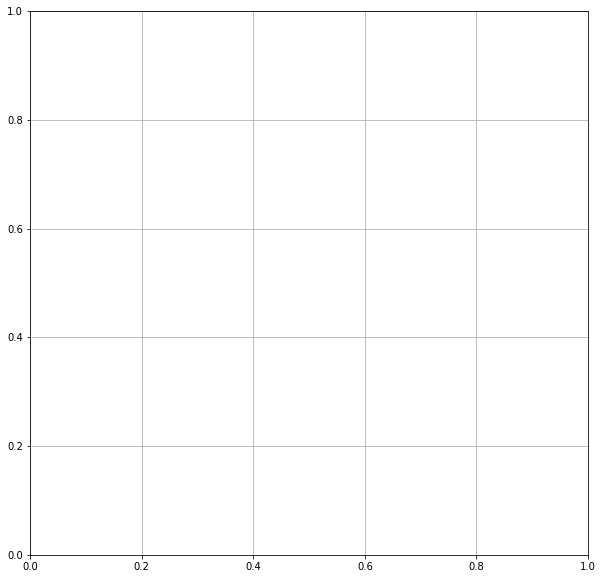

In [ ]:
#@title #### PREDICHAS VS REALIDAD
plt.figure(figsize=(10,10))
plt.grid()
plt.title(f"Nº Colonias (Error: {error_media:.2f} %)",fontsize=20)
plt.suptitle(f"Long.Dataset: {num_train} - MAE: {MAE:.2f} - Nº Epocas: {n_epochs}", fontsize=10)
plt.xlabel("Realidad",fontsize=18)
plt.ylabel("Predichas",fontsize=18)
plt.scatter(colonias_true_v,colonias_pred_v,s=15,label="Sin filtrar")
plt.scatter(colonias_true_v,colonias_pred_filt_v,s=15,c='r',label="Filtradas")
plt.legend()
maximo= max([max(colonias_true_v),max(colonias_pred_v)])
plt.plot([0, maximo], [0, maximo], '--k')

import altair as alt
alt.Chart(df_colonias).mark_circle(size=20).encode(
    x='Colonias Reales',
    y='Colonias Post-Filtro',
    color='Fallo Catalogacion',
    tooltip=['Fallo Catalogacion','Colonias Post-Filtro','Colonias Reales','Nombre imagen']
).interactive()





# **RESULTADOS EN PDF (POST - FILTRADO)**


---



In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(f'/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/{id}-{id_analisis}-{tipo_patogeno}-(Err-{error_media:.2f}).pdf')

# Primera pagina - titulo 
fig = plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)
ax.text(5,5,f'{tipo_analisis}\n\n{tipo_patogeno}\n\n\nModelo:{Nombre_Fichero_modelo_a_validar}',horizontalalignment='center', verticalalignment='center',fontsize=30)
ax.axis([0,10,0,10])
ax.grid(False)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.axis('off')
pdf.savefig()  # saves the current figure into a pdf page
plt.close()

# Plot de regesion 
plt.figure(figsize=(8,8))
plt.grid()
plt.title(f"Nº Colonias (Error: {error_media:.2f} %)",fontsize=20)
plt.suptitle(f"Filtro utilizado: {tipo_filtro} - IOU Thres {iou_threshold} - Dist.Euclidea Thresh: {dist_eucl_threshold} - Score Thresh: {score_threshold}\nMétricas: MAE: {MAE:.2f} - Media colonias: {media_real:.2f}", fontsize=10)
plt.xlabel("Realidad",fontsize=18)
plt.ylabel("Predichas",fontsize=18)
plt.scatter(colonias_true_v,colonias_pred_v,s=15,label="Sin filtrar")
plt.scatter(colonias_true_v,colonias_pred_filt_v,s=15,c='r',label="Filtradas")
plt.legend()
maximo= max([max(colonias_true_v),max(colonias_pred_v)])
plt.plot([0, maximo], [0, maximo], '--k')
pdf.savefig()  # saves the current figure into a pdf page
plt.close()
#pdf.close()

# Plot graficos catalogacion de placas
if tipo_analisis == 'Aguas - Deteccion':
  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)
  fig.subplots_adjust(wspace=0)

  ratios = [placas_correctas,placas_erroneas]
  explode = [0, 0]
  angle = -180 * ratios[0]
  ax1.set_title('RESUMEN CATALOGACIÓN PLACAS')
  ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
          labels=ratios, explode=explode,textprops={'fontsize': 20})
  ax1.legend(('PLACAS BIEN CATALOGADAS', 'PLACAS MAL CATALOGADAS'))


  ratios = [placas_erroneas_FP,placas_erroneas_FN]
  colors = [[.2, .8, .5], [.8, .3, .3]]
  width=0.01

  for j in range(len(ratios)):
      height = ratios[j]
      ax2.bar(0, height, 0.015, bottom=bottom, color=colors[j])
      ypos = bottom + ax2.patches[j].get_height() / 2
      bottom += height
      if ratios[j] !=0:
        ax2.text(0, ypos,f"%d%% - {ratios[j]}" % (ratios[j]/sum(ratios) * 100),
                ha='center',fontsize=20)
      
  ax2.set_title('DESGLOSE PLACAS MAL CATALOGADAS')
  ax2.legend(('FALSOS POSITIVOS', 'FALSOS NEGATIVOS'))
  ax2.axis('off')
  ax2.set_xlim(- 2.5 * width, 2.5 * width)
  pdf.savefig()  # saves the current figure into a pdf page
  plt.close()


# Plot dataframe
# fig = plt.figure(figsize=(16,9))
# ax=fig.add_subplot(111)
# ax.axis([0,10,0,10])
# ax.grid(False)
# ax.spines['left'].set_linewidth(0)
# ax.spines['right'].set_linewidth(0)
# ax.spines['bottom'].set_linewidth(0)
# ax.spines['top'].set_linewidth(0)
# plt.axis('off')
df_colonias.plot()
pdf.savefig()  # saves the current figure into a pdf page
plt.close()

#Ploteamos prediccion e imagenes
for i in indices_erroneas:
  fig = plt.figure(figsize=(7,7))
  ax = fig.add_axes([0.1,0.1,0.8,0.8],xticks=[],yticks=[])
  ax.spines['left'].set_linewidth(0)
  ax.spines['right'].set_linewidth(0)
  ax.spines['bottom'].set_linewidth(0)
  ax.spines['top'].set_linewidth(0) 

  npimg=imgs[i].numpy()  
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show
      
  colonias = len(boxes_pred_filt[i])
  plt.title(f"No Colonias: {colonias} --> Realidad: {colonias_true_v[i]} --> MAL CATALOGADA\n\nImagen: {filename_img_v[i]}",color="black",fontsize=10,fontweight='bold')
    
  index=0;
  for i in boxes_pred_filt[i]:
    index+=1
    xmax =int(i[2])
    ymax =int(i[3])
    xmin =int(i[0])
    ymin =int(i[1])
    width = xmax-xmin
    heigth = ymax-ymin
    rect = patches.Rectangle((xmin,ymin), width, heigth, edgecolor ='r', facecolor = 'none',linewidth=1)
    #ax.annotate(f"{index}",(xmin,ymin),color='b')
    ax.add_patch(rect)

  pdf.savefig()  # saves the current figure into a pdf page
  plt.close()

for i in range(len_dataset_test):
  index=0
  xmax_filt = []
  ymax_filt = []
  xmin_filt = []
  ymin_filt = []

  if i in indices_erroneas:
    continue

  fig = plt.figure(figsize=(7,7))
  ax = fig.add_axes([0.1,0.1,0.8,0.8],xticks=[],yticks=[])
  ax.spines['left'].set_linewidth(0)
  ax.spines['right'].set_linewidth(0)
  ax.spines['bottom'].set_linewidth(0)
  ax.spines['top'].set_linewidth(0) 

  npimg=imgs[i].numpy()  
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show
      
  colonias = len(boxes_pred_filt[i])
  plt.title(f"No Colonias: {colonias} --> Realidad: {colonias_true_v[i]}\n\nImagen: {filename_img_v[i]}",color="black",fontsize=10,fontweight='bold')
    
  for j in boxes_pred_filt[i]:
    
    xmax_filt.append(int(j[2]))
    ymax_filt.append(int(j[3]))
    xmin_filt.append(int(j[0]))
    ymin_filt.append(int(j[1]))
    width = xmax_filt[index]-xmin_filt[index]    
    heigth = ymax_filt[index]-ymin_filt[index]
    rect = patches.Rectangle((xmin_filt[index],ymin_filt[index]), width, heigth, edgecolor ='r', facecolor = 'none',linewidth=1)
    #ax.annotate(f"{index}",(xmin,ymin),color='b')
    ax.add_patch(rect)
    index+=1

  
  # for z in boxes[i]:
  #   no_pintar = 0
    
  #   xmax =int(z[2])
  #   ymax =int(z[3])
  #   xmin =int(z[0])
  #   ymin =int(z[1])

  #   for w in range(len(boxes_pred_filt[i])):
  #     if (np.abs(xmax - xmax_filt[w]) < 20) and (np.abs(ymax - ymax_filt[w]) < 20) and (np.abs(xmin - xmin_filt[w]) < 20) and (np.abs(ymin - ymin_filt[w]) < 20):
  #       no_pintar = 1
  #       continue

  #   if no_pintar:
  #     continue
  #   width = xmax-xmin
  #   heigth = ymax-ymin
  #   rect = patches.Rectangle((xmin,ymin), width, heigth, edgecolor ='b', facecolor = 'none',linewidth=1)
  #   #ax.annotate(f"{index}",(xmin,ymin),color='b')
  #   ax.add_patch(rect)

  pdf.savefig()  # saves the current figure into a pdf page
  plt.close()

pdf.close()

**GUARDAMOS INFORMACION EN TXT**


In [ ]:
file = open(f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/training_info.txt","a")
file.write(f"\n{error_media:.2f},{MSE:.2f},{RMSE:.2f},{MAE:.2f},{media_real:.2f},{batch_size},{learning_rate},{momentum},{weight_decay},{n_epochs},{num_train}") 
file.close()

In [ ]:
# Informacion acumulada en el txt
dataframe = pd.read_csv(f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/training_info.txt")
dataframe


REQUIREMENTS.TXT


In [ ]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

torchvision==0.7.0+cu101
torch==1.6.0+cu101
scikit-learn==0.22.2.post1
Pillow==7.0.0
pathlib==1.0.1
pandas==1.0.5
numpy==1.18.5
matplotlib==3.2.2
google==2.0.3
